# Predict the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 70/20/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 198.35
- MAE: 157.40
- MAPE: 1.43 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> ITD - 7 2 1
split = 0
stock = 2  # ITD

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1247,2024-02-26,9520,9700,9510,9700,8700,ITD
1248,2024-02-27,9690,9690,9210,9640,17500,ITD
1249,2024-02-28,9450,10000,9400,9890,35700,ITD
1250,2024-02-29,9890,9960,9430,9950,53400,ITD


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [39]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [40]:
# Shape of the dataframe
df.shape

(1252, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,9957.242013,10146.194089
std,2982.882283,3069.392776
min,5130.000000,5320.000000
25%,7430.000000,7515.000000
50%,9825.000000,10000.000000
75%,11550.000000,11700.000000
max,20700.000000,21430.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

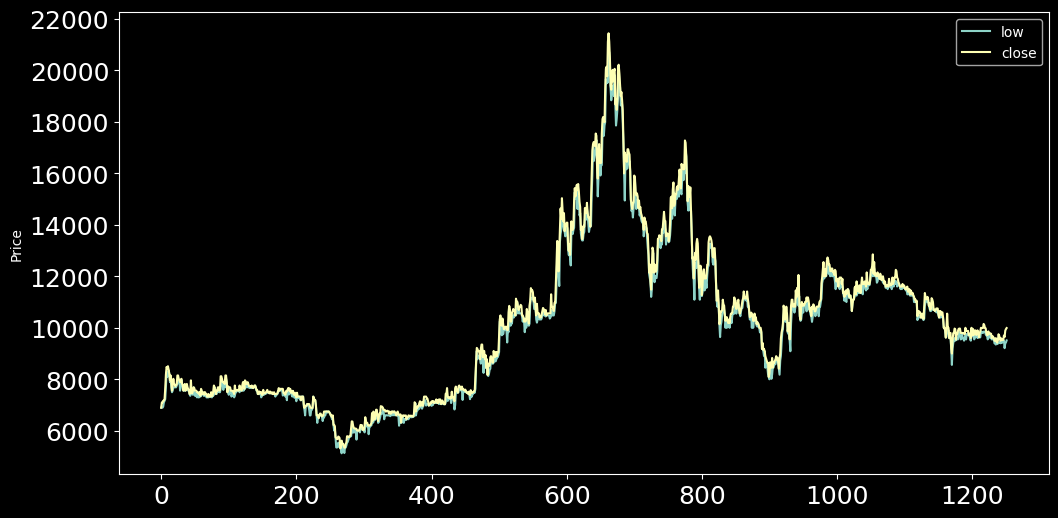

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.6093516999032065,
 0.4788943246246586,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 17400.706231746055)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.778
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.790
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


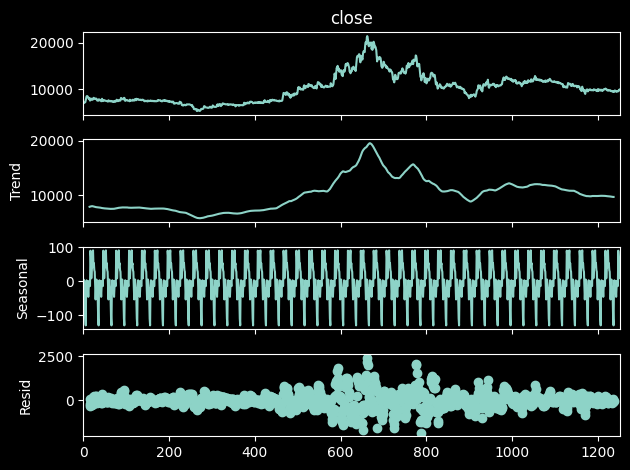

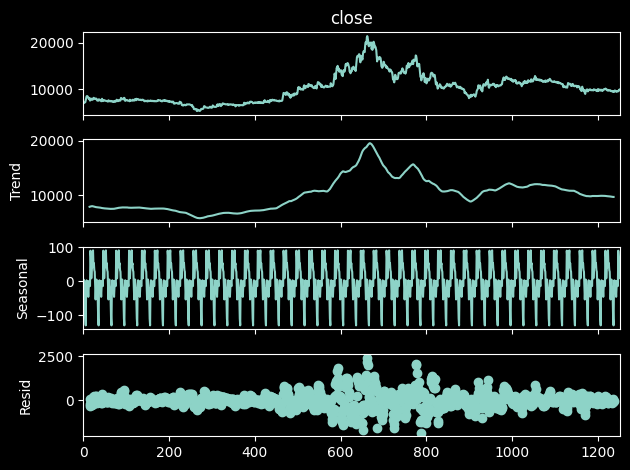

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-8.95891896280251,
 8.326686071796932e-15,
 11,
 863,
 {'1%': -3.4379500665211276,
  '5%': -2.864894878219008,
  '10%': -2.5685563904109867},
 12196.523759023963)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

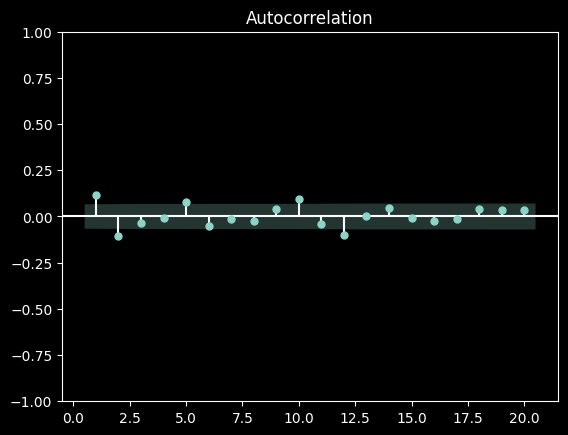

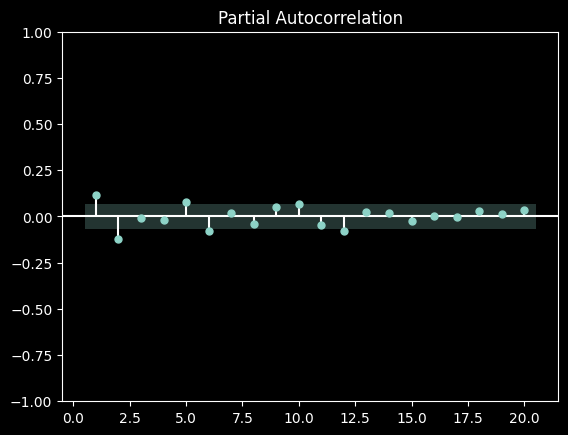

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=12503.462, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=12528.472, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=12514.016, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=12511.385, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=12526.622, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=12506.472, Time=0.33 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=12505.150, Time=0.53 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=12500.295, Time=1.03 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=12500.903, Time=1.03 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=12501.482, Time=1.27 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=12501.646, Time=1.34 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=12498.569, Time=0.74 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=12502.707, Time=0.43 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=12500.311, Time=0.58 sec
 ARIMA(1,1,2)(2,0,2

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  876
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 5)   Log Likelihood               -6241.457
Date:                             Sun, 26 May 2024   AIC                          12496.914
Time:                                     13:33:50   BIC                          12530.333
Sample:                                          0   HQIC                         12509.698
                                             - 876                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6768      0.116      5.830      0.000       0.449       0.904
ma.L1         -0.5360      

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(1, 1, 2),
    seasonal_order=(2, 0, 1, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([10187.89238813, 10461.13552513, 10462.89230621, 10567.13371708,
       10504.93889747, 10285.08292119, 10244.21334734, 10248.62137816,
       10295.63836468, 10192.03702166, 10017.93777638, 10109.12854237,
       10014.19168652,  9367.30683797,  9369.99232164,  9273.32104207,
        9090.83721985,  9276.83250799,  8628.7340833 ,  8827.16150203,
        8731.71343263,  8640.7481175 ,  8362.54750101,  8262.54133475,
        8175.23435658,  8513.63334376,  8604.53499558,  8193.24743965,
        8354.97364417,  8634.56850505,  8630.21257011,  8731.62441253,
        8768.30170092,  8768.52689299,  8914.09654176,  8928.55708276,
        8999.22689905,  8780.29784483,  8587.70301154,  8351.00590863,
        8913.5803933 ,  9095.99124849,  9598.37722283, 10013.6839248 ,
       10149.12988145, 10609.05284863, 10882.20394054, 10470.92125355,
       10430.18786082, 10517.46248543, 10756.06940507, 10017.2197484 ,
        9962.80793034,  9922.5470213 ,  9693.53258922,  9272.69976118,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([10592.84334456, 10542.12571642, 10493.26362795, 10597.50503881,
       11041.49891475, 11206.34634709, 11256.59073843, 11260.99876925,
       11216.90179058, 11204.41441276, 11060.6864892 , 10959.52555089,
       10854.46492113, 10855.50160288, 10959.42482565, 11004.48638084,
       10902.99274991, 10906.76010765, 10906.58321326, 10851.91628422,
       10857.70595393, 10807.23573444, 10854.00826049, 10803.6085864 ,
       10706.17783431, 10599.13076942, 10598.91845604, 10602.70563046,
       10653.07032196, 10649.19951333, 10604.34848274, 10553.9037165 ,
       10195.75382236, 10195.97901443, 10098.57808934,  9809.32541301,
        9839.50013366, 10197.62619236, 10015.15513298, 10102.41879522,
        9794.34872355,  9794.53164834,  9790.72892714,  9386.00994233,
        8741.92530783,  9384.07620541,  9586.36087994,  9701.51443632,
        9792.39010443,  9687.31302473,  9723.44446615,  9733.75407889,
        9790.70377386,  9740.31909091, 10047.8646761 ,  9991.48770885,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1247,9510,9700
1248,9210,9640
1249,9400,9890
1250,9430,9950


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[18135.56646702 18145.59473819 18157.47854902 18221.22812008
 18169.16033022 18192.27818365 18202.03073519 18216.56579576
 18233.21471639 18230.85436832 18249.11008318 18259.31391372
 18265.61805283 18276.78176433 18289.59427775 18294.16399313
 18304.03513106 18317.92951855 18327.87965391 18333.95862417
 18349.87532364 18360.15100345 18366.4316897  18376.77791491
 18390.71193168 18395.02963565 18404.94435202 18418.85855619
 18428.73140789 18434.98762901]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

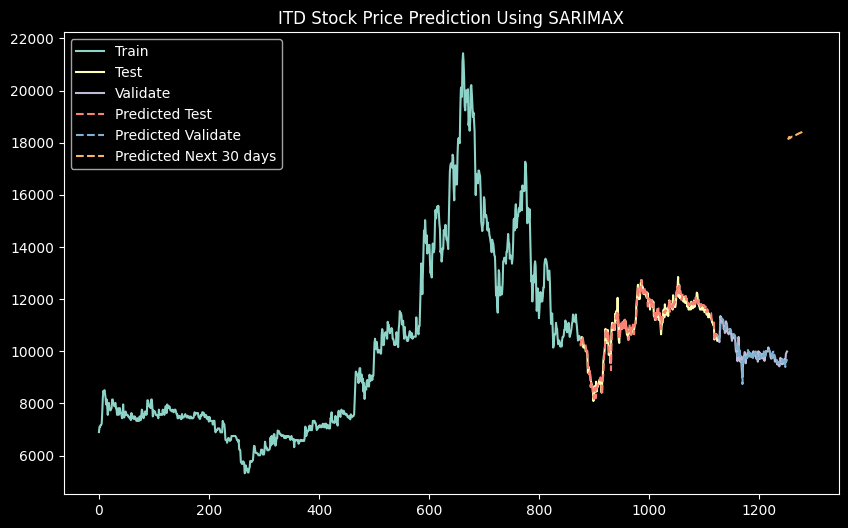

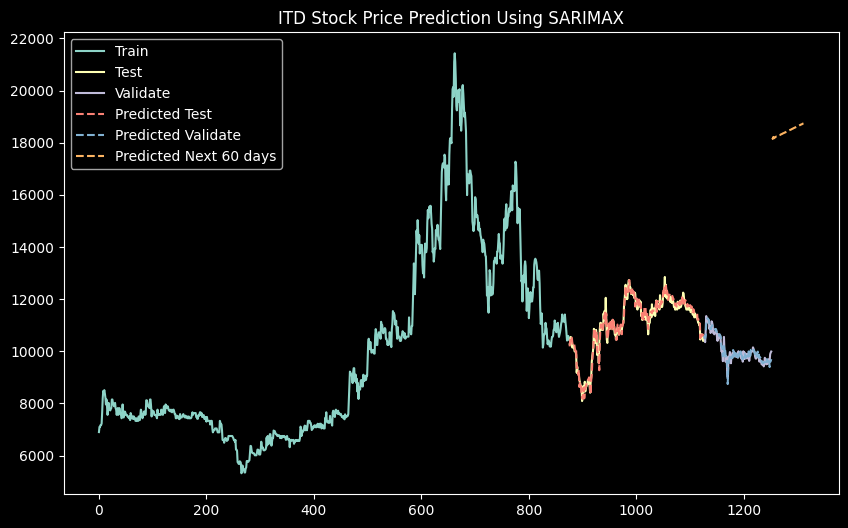

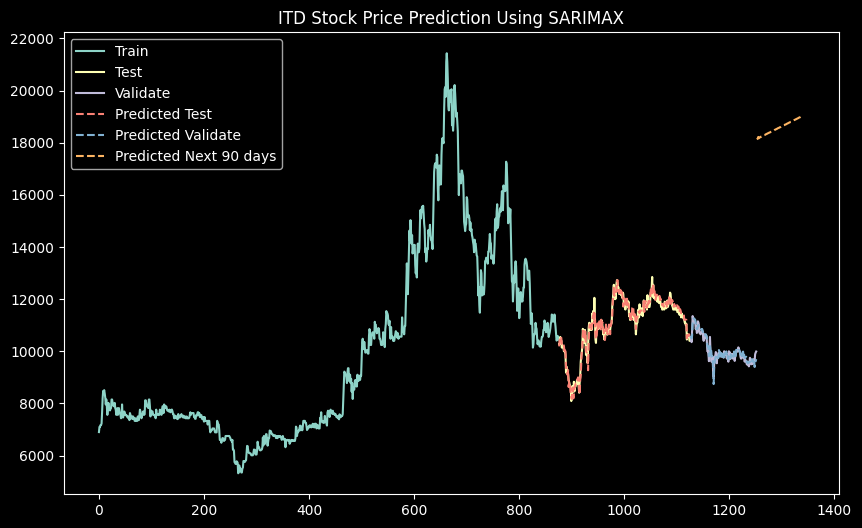

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 198.3548295077272
MAE on test data: 157.39604258032068
MAPE on test data: 1.4339188701419407 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 140.15508037031913
MAE on validation data: 116.9375373986849
MAPE on validation data: 1.167927115358331 %
